In [1]:
# data manipulation 
import numpy as np
import pandas as pd

from datetime import datetime
import itertools

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR

from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics

import math

# data visualization 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from pylab import rcParams

%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

from proj_acquire import *
from proj_prepare import *

import zgulde.extend_pandas as ep

In [62]:
df = prepare_fitbit()

In [63]:
# rename index to date
df.rename(columns={'index': 'date'}, inplace=True)

# set date to index
df.set_index('date', inplace=True)

# dropping columns with mostly zero information
to_drop = ['calories', 'carbs', 'fat', 'fiber',
       'protien', 'sodium', 'water']
df = df.drop(columns=(to_drop))

# remove commas and convert to float64
for col in df:
    df[col] = df[col].str.replace(',', '')
    df[col] = df[col].astype('float64')

# drop NaN rows as we'll be predicting them anyway
df.dropna(inplace=True)

In [6]:
for col in df:
    print(f'{col} outliers:{df[col].outliers().sum()}')

activity_calories outliers:3
distance outliers:1
floors outliers:12
mins_active_high outliers:0
mins_active_light outliers:17
mins_active_med outliers:11
mins_sedentary outliers:22
steps outliers:1
total_calories outliers:4


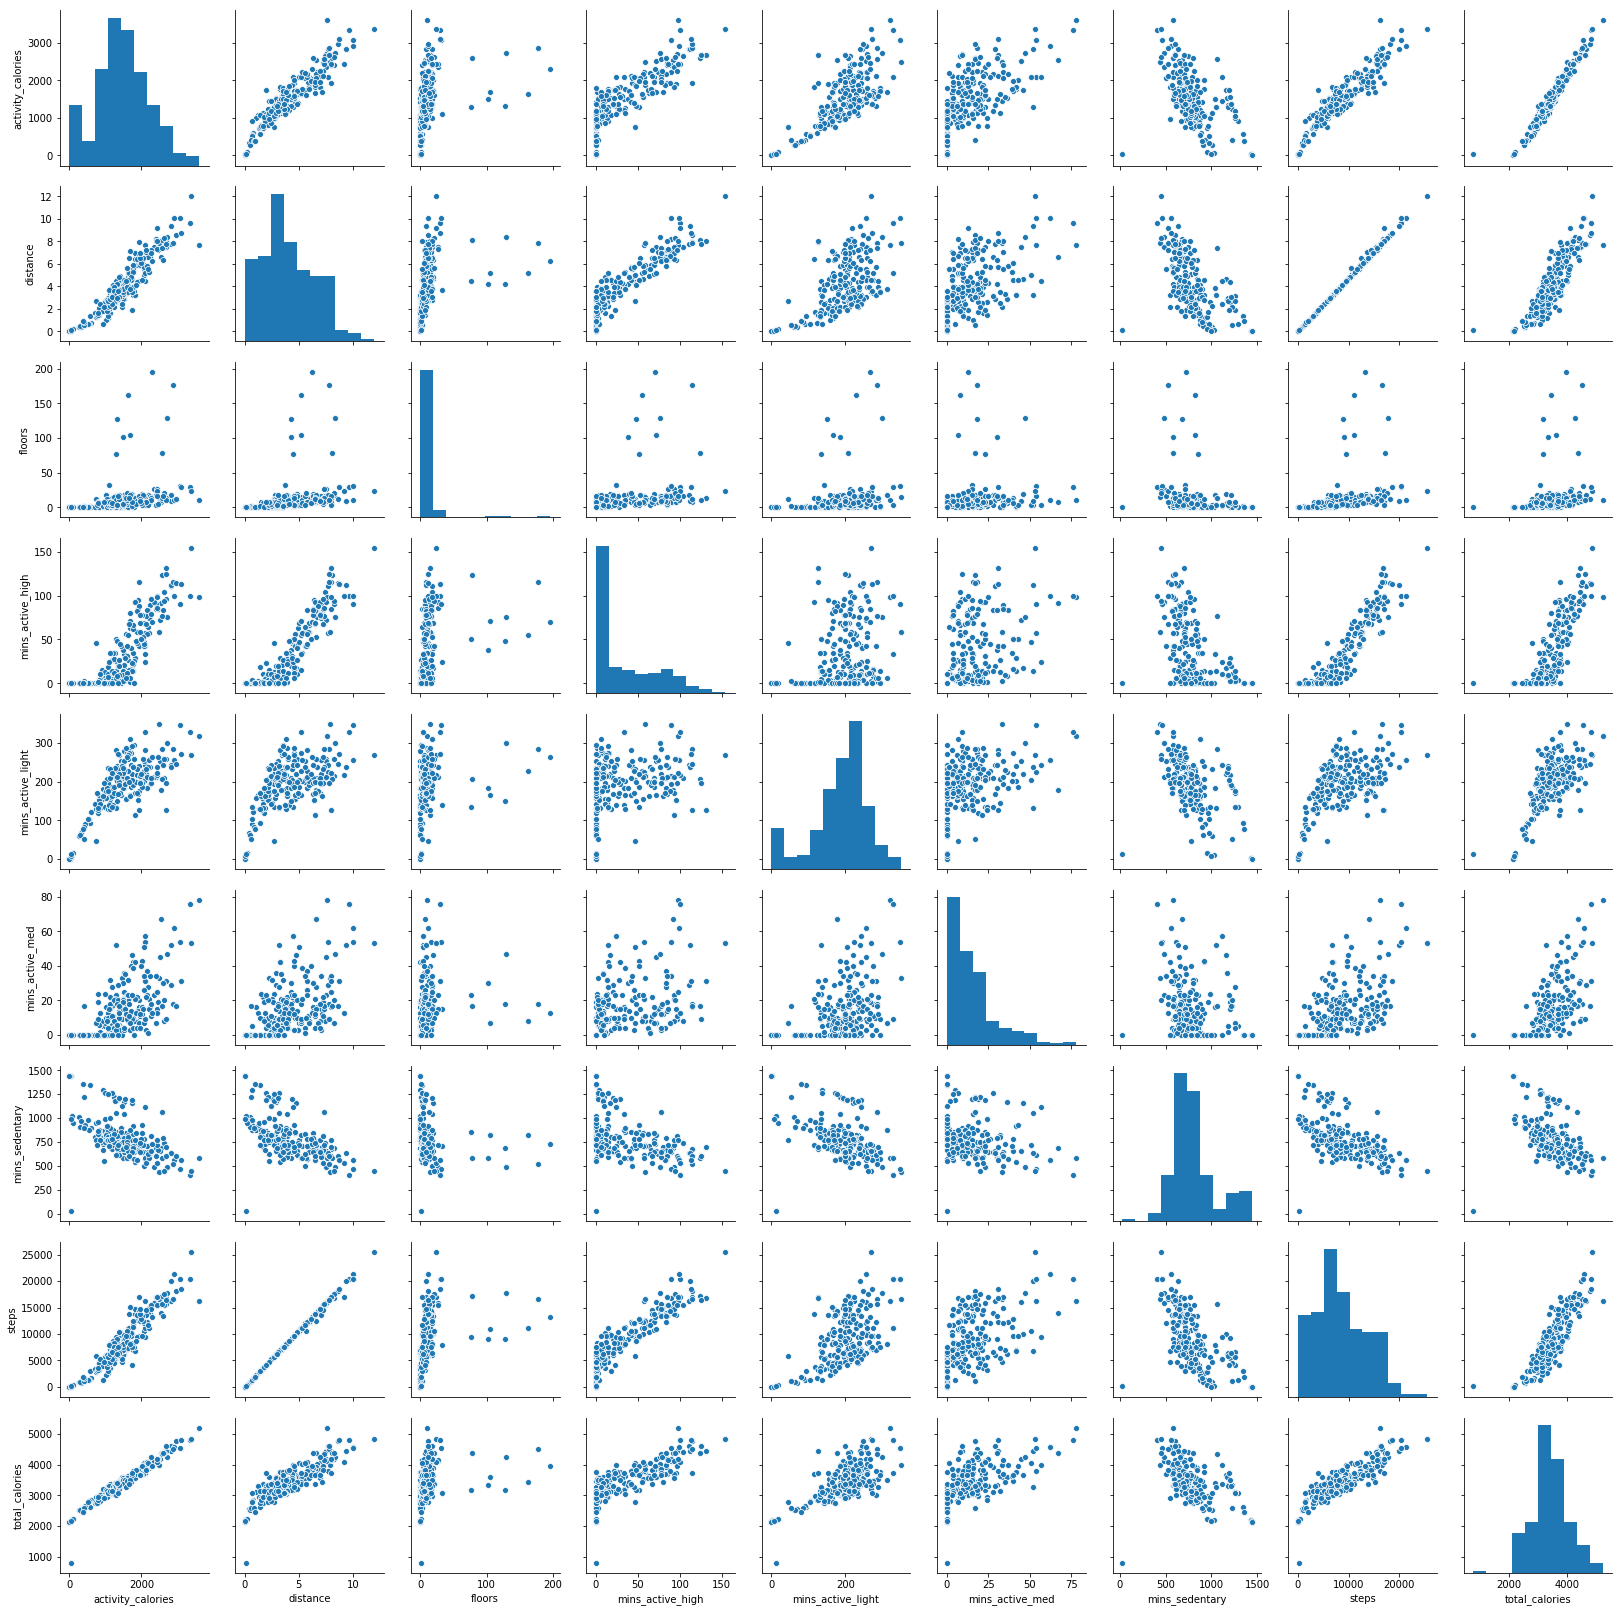

In [7]:
sns.pairplot(df)

<module 'matplotlib.pyplot' from '/usr/local/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

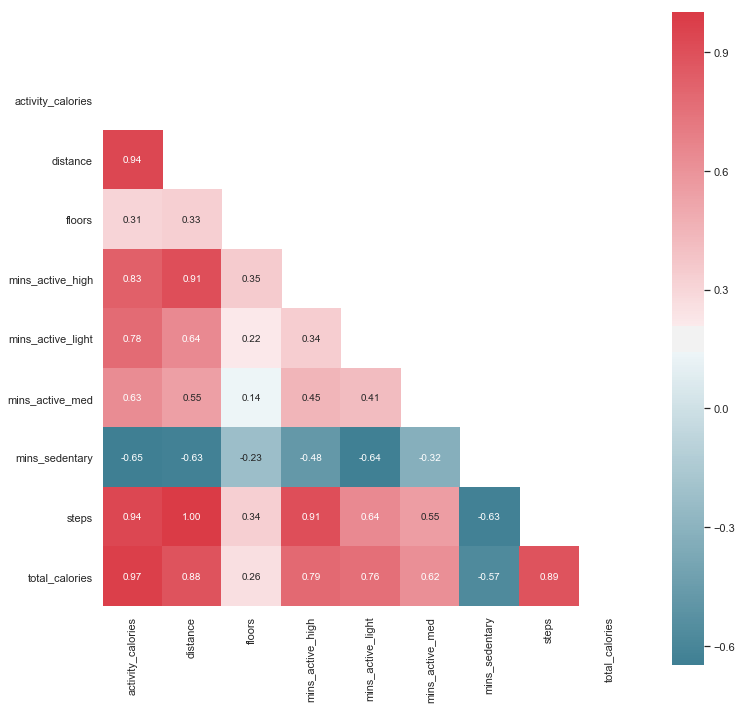

In [8]:
df.correlation_heatmap(fancy=True)

In [ ]:
def peekatdata(df):
    '''gives cursory sample of dataframe passed'''
    head_df = df.head(5)
    print(head_df)
    tail_df = df.tail(5)
    print(tail_df)
    shape_tuple = df.shape
    print(shape_tuple)
    describe_df = df.describe()
    print(describe_df)
    df.info()

In [7]:
train = df['2018-04':'2018-09']
test = df['2018-10':'2018-12']
print(train.nunique())
print(test.nunique())

activity_calories    145
distance             130
floors                25
mins_active_high      60
mins_active_light    108
mins_active_med       46
mins_sedentary       131
steps                146
total_calories       145
dtype: int64
activity_calories    65
distance             63
floors               31
mins_active_high     50
mins_active_light    53
mins_active_med      32
mins_sedentary       61
steps                67
total_calories       67
dtype: int64


# Exploration

### mean total calories by day

Text(0.5, 0, 'day')

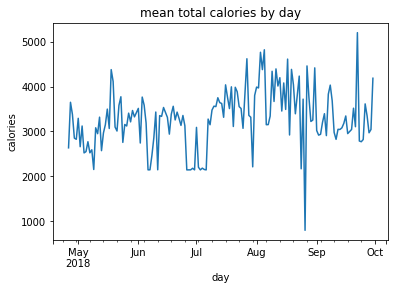

In [8]:
t_cal = train.resample('D').total_calories.mean()
t_cal.plot()
plt.title('mean total calories by day')
plt.ylabel('calories')
plt.xlabel('day')

### mean total calories by week

Text(0.5, 0, 'weeks')

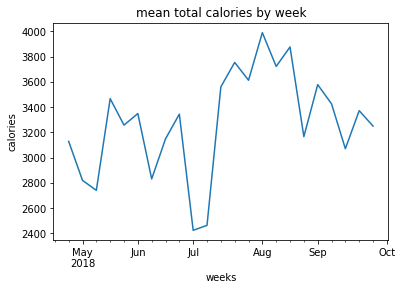

In [9]:
t_cal.resample('W').mean().plot()
plt.title('mean total calories by week')
plt.ylabel('calories')
plt.xlabel('weeks')

### mean total calories by month

Text(0.5, 0, 'month')

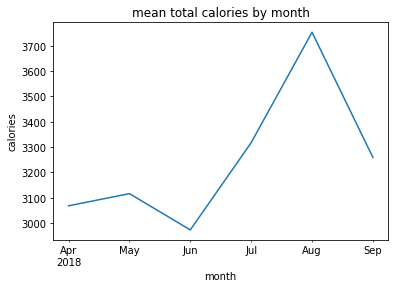

In [10]:
t_cal.resample('M').mean().plot()
plt.title('mean total calories by month')
plt.ylabel('calories')
plt.xlabel('month')

### 5 period rolling mean and plot

In [11]:
t_cal.head(10)

date
2018-04-26    2635.0
2018-04-27    3649.0
2018-04-28    3379.0
2018-04-29    2851.0
2018-04-30    2825.0
2018-05-01    3292.0
2018-05-02    2660.0
2018-05-03    3121.0
2018-05-04    2522.0
2018-05-05    2551.0
Freq: D, Name: total_calories, dtype: float64

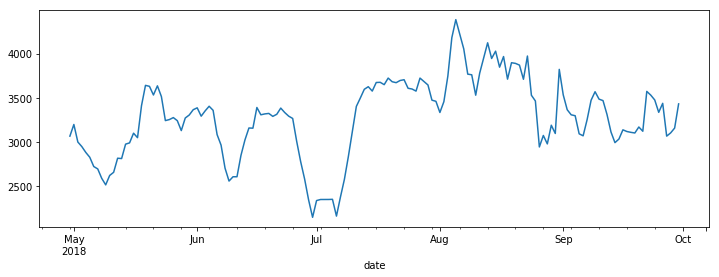

In [12]:
t_cal.rolling(5).mean().plot(figsize=(12, 4))

### 10 period rolling mean and plot

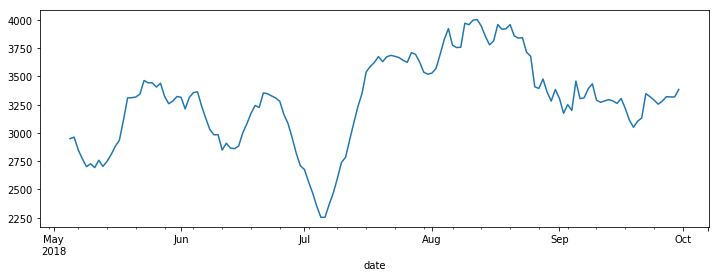

In [13]:
t_cal.rolling(10).mean().plot(figsize=(12, 4))

### Time-series decomposition - trend, seasonality, and noise

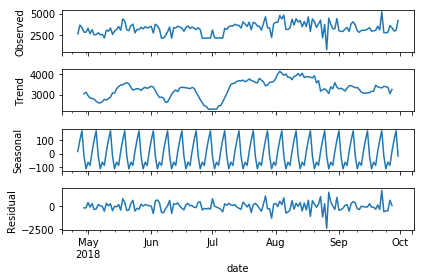

In [14]:
decomposition = sm.tsa.seasonal_decompose(t_cal, model='additive')
fig = decomposition.plot()
plt.show()

### lag plot

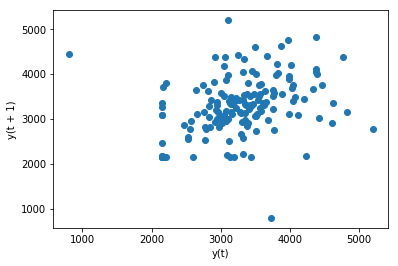

In [15]:
pd.plotting.lag_plot(t_cal)

### pearson's correlation coef

In [16]:
df_corr = pd.concat([t_cal.shift(1), t_cal], axis=1)
df_corr.columns = ['t-1','t+1']
result = df_corr.corr()
print(result)

          t-1       t+1
t-1  1.000000  0.317357
t+1  0.317357  1.000000


# Modeling

In [17]:
agg1 = 'mean'
agg2 = 'sum'

In [18]:
ts_data1 = df.total_calories.resample('W').agg(agg1)
ts_data2 = df.total_calories.resample('W').agg(agg2)

In [19]:
train_size1 = int(len(ts_data1) * 0.66)
train_1, test_1 = ts_data1[0:train_size1], ts_data1[train_size1:len(ts_data1)]
print('Observations: %d' % (len(ts_data1)))
print('Training Observations: %d' % (len(train_1)))
print('Testing Observations: %d' % (len(test_1)))

train_size2 = int(len(ts_data2) * 0.66)
train_2, test_2 = ts_data2[0:train_size2], ts_data2[train_size2:len(ts_data2)]
print('Observations: %d ' % (len(ts_data2)))
print('Training Observations: %d' % (len(train_2)))
print('Testing Observations: %d' % (len(test_2)))

Observations: 33
Training Observations: 21
Testing Observations: 12
Observations: 33 
Training Observations: 21
Testing Observations: 12


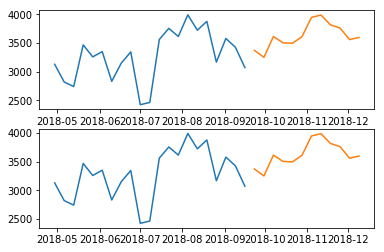

In [20]:
plt.subplot(211)
plt.plot(train_1)
plt.plot(test_1)

plt.subplot(212)
plt.plot(train_1)
plt.plot(test_1)

plt.show()

### Simple Average

In [21]:
train = df['2018-04':'2018-09'].total_calories.resample('D').agg('mean')
test = df['2018-10':'2018-12'].total_calories.resample('D').agg('mean')
print('Observations: %d' % (len(train.values) + len(test.values)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 225
Training Observations: 158
Testing Observations: 67


In [22]:
yhat = pd.DataFrame(dict(actual=test))
yhat['avg_forecast'] = train.mean()
yhat['diff'] = yhat['actual'] - yhat['avg_forecast']
yhat.head()

,actual,avg_forecast,diff
date,,,
2018-10-01,3180.0,3278.968354,-98.968354
2018-10-02,3162.0,3278.968354,-116.968354
2018-10-03,3584.0,3278.968354,305.031646
2018-10-04,3713.0,3278.968354,434.031646
2018-10-05,3603.0,3278.968354,324.031646


In [23]:
def plot_data_and_predictions(predictions, label):
    plt.figure(figsize=(10, 8))

    plt.plot(train,label='Train')
    plt.plot(test, label='Test')
    plt.plot(predictions, label=label, linewidth=5)

    plt.legend(loc='best')
    plt.show()


def evaluate(actual, predictions, output=True):
    mse = metrics.mean_squared_error(actual, predictions)
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse    

def plot_and_eval(predictions, actual=test, metric_fmt='{:.2f}', linewidth=4):
    if type(predictions) is not list:
        predictions = [predictions]

    plt.figure(figsize=(16, 8))
    plt.plot(train,label='Train')
    plt.plot(test, label='Test')

    for yhat in predictions:
        mse, rmse = evaluate(actual, yhat, output=False)        
        label = f'{yhat.name}'
        if len(predictions) > 1:
            label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.plot(yhat, label=label, linewidth=linewidth)

    if len(predictions) == 1:
        label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.title(label)

    plt.legend(loc='best')
    plt.show()    

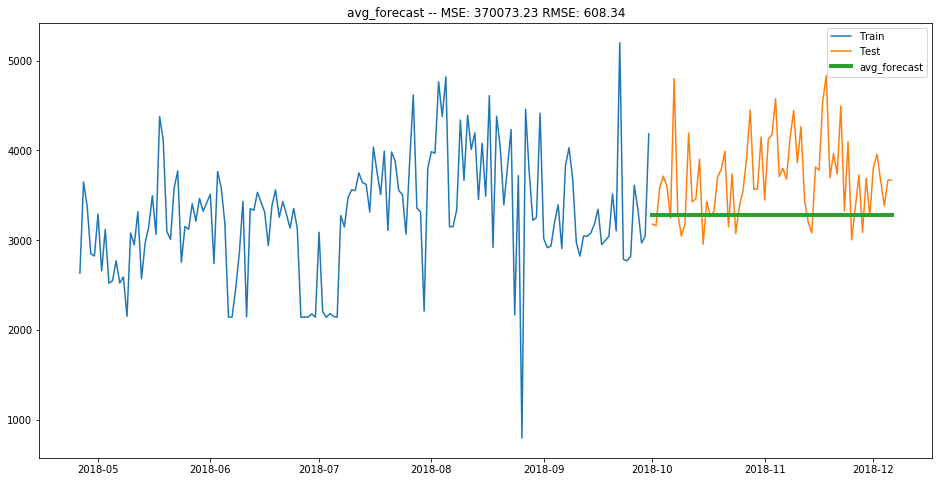

In [24]:
plot_and_eval(yhat.avg_forecast)

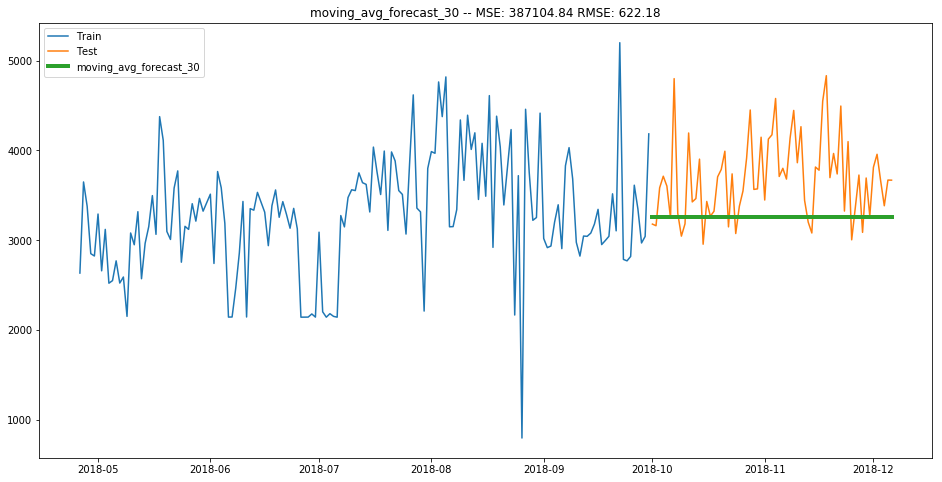

In [25]:
periods = 30
yhat['moving_avg_forecast_30'] = train.rolling(30).mean().iloc[-1]

plot_and_eval(yhat.moving_avg_forecast_30)

In [26]:
yhat.head()

,actual,avg_forecast,diff,moving_avg_forecast_30
date,,,,
2018-10-01,3180.0,3278.968354,-98.968354,3258.833333
2018-10-02,3162.0,3278.968354,-116.968354,3258.833333
2018-10-03,3584.0,3278.968354,305.031646,3258.833333
2018-10-04,3713.0,3278.968354,434.031646,3258.833333
2018-10-05,3603.0,3278.968354,324.031646,3258.833333


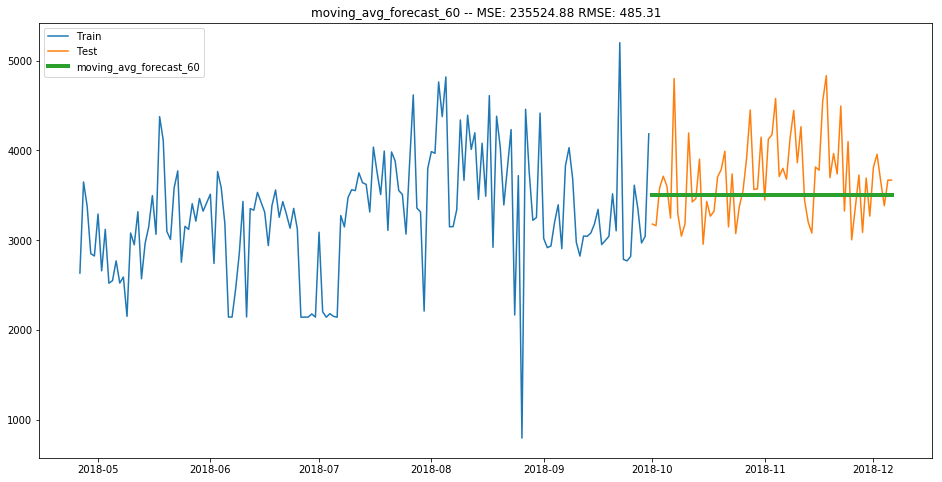

In [27]:
yhat['moving_avg_forecast_60'] = train.rolling(60).mean().iloc[-1]

plot_and_eval(yhat.moving_avg_forecast_60)

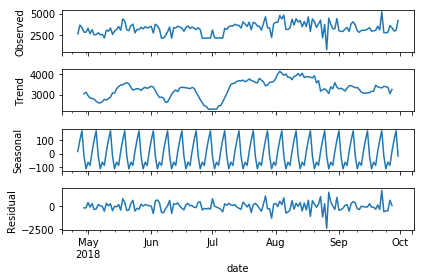

In [30]:
import statsmodels.api as sm

sm.tsa.seasonal_decompose(train).plot()
result = sm.tsa.stattools.adfuller(train)
plt.show()

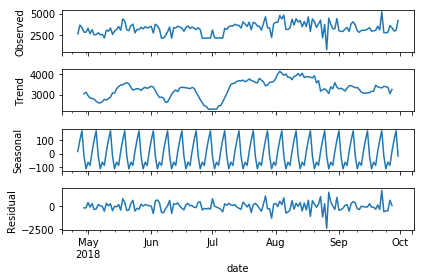

In [31]:
# train = df['2018-04':'2018-09'].total_calories.resample('D').agg('mean')
# test = df['2018-10':'2018-12'].total_calories.resample('D').agg('mean')

sm.tsa.seasonal_decompose(train).plot()
result = sm.tsa.stattools.adfuller(train)
plt.show()

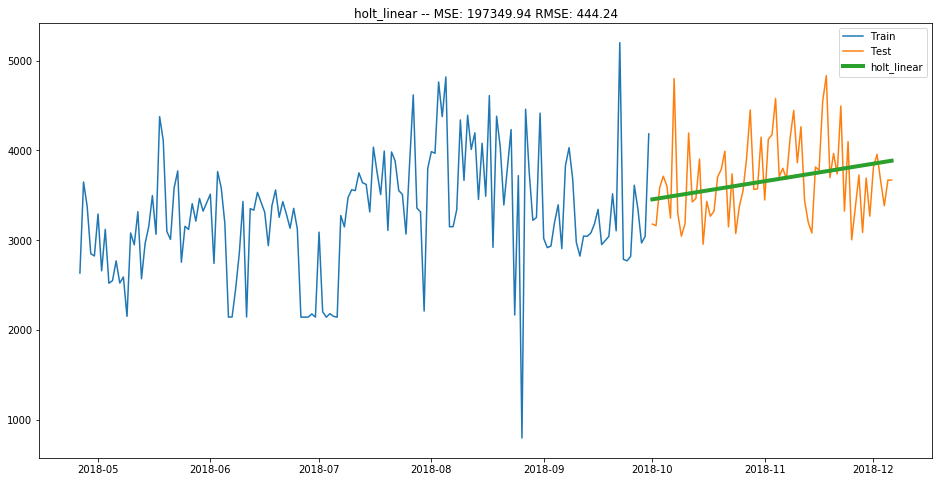

In [32]:
from statsmodels.tsa.api import Holt

holt = Holt(train).fit(smoothing_level=.3, smoothing_slope=.05)

yhat['holt_linear'] = holt.forecast(test.shape[0])

plot_and_eval(yhat.holt_linear)

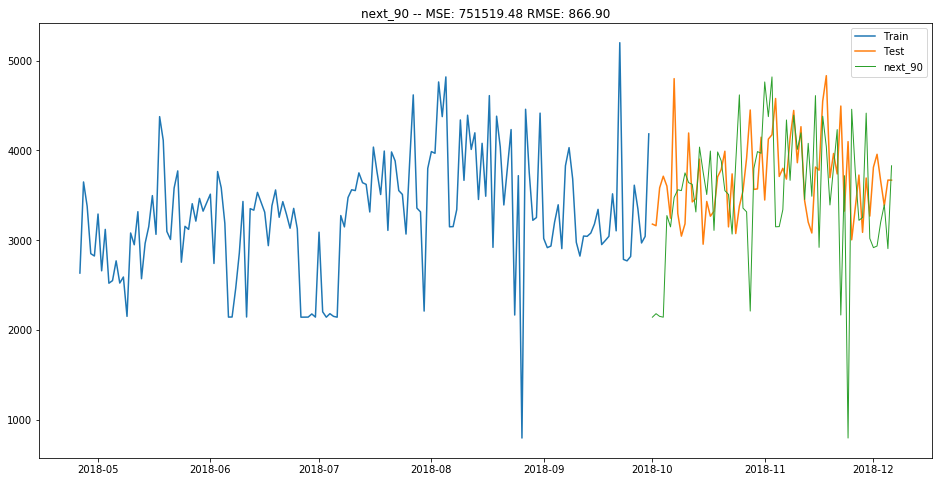

In [34]:
using_last_quarter = train['2018-07':'2018-09']\
    .reset_index()\
    .drop(columns='date')\
    .set_index(train['2018-07':'2018-09'].index+90)
yhat['next_90'] = using_last_quarter
plot_and_eval(yhat.next_90, linewidth=1)

# Prophet

In [36]:
df.columns

Index(['activity_calories', 'distance', 'floors', 'mins_active_high',
       'mins_active_light', 'mins_active_med', 'mins_sedentary', 'steps',
       'total_calories'],
      dtype='object')

In [37]:
import seaborn as sns
from fbprophet import Prophet

In [39]:
df.reset_index(inplace=True)
df.head()

,date,activity_calories,distance,floors,mins_active_high,mins_active_light,mins_active_med,mins_sedentary,steps,total_calories
0,2018-04-26,566.0,1.38,2.0,0.0,93.0,0.0,1347.0,2931.0,2635.0
1,2018-04-27,1752.0,4.70,19.0,17.0,219.0,46.0,1158.0,9971.0,3649.0
2,2018-04-28,1124.0,1.66,2.0,11.0,155.0,22.0,702.0,3521.0,3379.0
3,2018-04-29,602.0,0.77,0.0,0.0,122.0,0.0,891.0,1639.0,2851.0
4,2018-04-30,540.0,0.62,0.0,0.0,104.0,0.0,880.0,1323.0,2825.0


In [41]:
d_df = pd.DataFrame()
d_df

""


In [43]:
d_df['y'] = df.distance
d_df['ds'] = pd.to_datetime(df['date'])

d_df = d_df.groupby(['ds'])['y'].sum().reset_index()

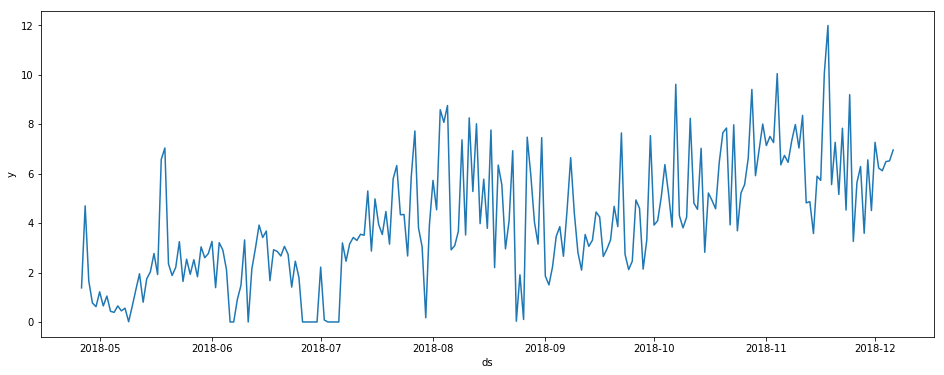

In [45]:
plt.figure(figsize=(16,6))
sns.lineplot(d_df.ds, d_df.y)

In [46]:
d_df.head()

,ds,y
0,2018-04-26,1.38
1,2018-04-27,4.70
2,2018-04-28,1.66
3,2018-04-29,0.77
4,2018-04-30,0.62


In [47]:
d_df['cap'] = 11
d_df['floor'] = 1

m = Prophet(daily_seasonality=True, growth='logistic',changepoint_range=0.9)
m.fit(d_df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [48]:
future = m.make_future_dataframe(periods=92)
future['cap'] = 11
future['floor'] = 1
print(future.head())
print(future.tail())
print(d_df.tail())

          ds  cap  floor
0 2018-04-26   11      1
1 2018-04-27   11      1
2 2018-04-28   11      1
3 2018-04-29   11      1
4 2018-04-30   11      1
            ds  cap  floor
312 2019-03-04   11      1
313 2019-03-05   11      1
314 2019-03-06   11      1
315 2019-03-07   11      1
316 2019-03-08   11      1
            ds     y  cap  floor
220 2018-12-02  6.23   11      1
221 2018-12-03  6.12   11      1
222 2018-12-04  6.49   11      1
223 2018-12-05  6.52   11      1
224 2018-12-06  6.96   11      1


In [49]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
312,2019-03-04,9.624572,7.081331,11.958390
313,2019-03-05,9.877969,7.546922,12.291456
314,2019-03-06,9.754186,7.351945,11.883477
315,2019-03-07,10.376313,8.105287,12.773334
316,2019-03-08,10.500458,8.125866,12.750296


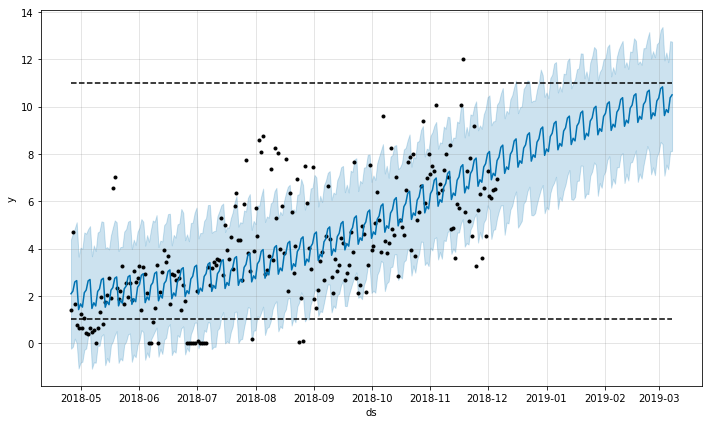

In [50]:
fig1 = m.plot(forecast)

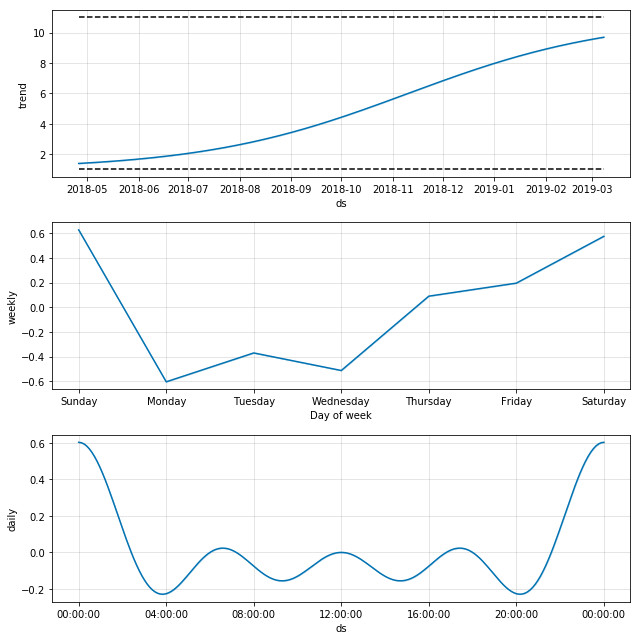

In [51]:
fig2 = m.plot_components(forecast)

In [52]:
from fbprophet.diagnostics import cross_validation, performance_metrics
# cross_validation(m, initial = 730, period = 180, horizon = 365, units = 'days')
df_cv = cross_validation(m, horizon='30 days')


df_p = performance_metrics(df_cv)

INFO:fbprophet:Making 7 forecasts with cutoffs between 2018-08-08 00:00:00 and 2018-11-06 00:00:00


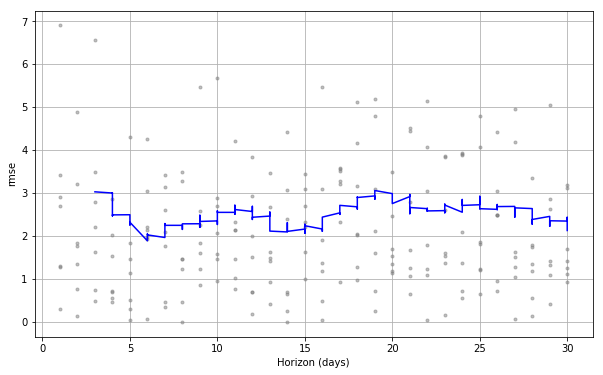

In [53]:
from fbprophet.plot import plot_cross_validation_metric, plot_forecast_component

# plot_forecast_component(m, forecast, 'yhat')

fig3 = plot_cross_validation_metric(df_cv, metric='rmse')

In [54]:
from datetime import timedelta, datetime
import itertools

In [66]:
df.reset_index('date', inplace=True)

In [67]:
# - Write a function to parse a date column into 6 additional 
# columns (while keeping the original date): year, quarter, month, day of month, day of week, weekend vs. weekday
def add_date_parts(df):
    df = df.copy()
    df['year'] = df.date.dt.year
    df['quarter'] = df.date.dt.quarter
    df['month'] = df.date.dt.month
    df['day'] = df.date.dt.day
    df['hour'] = df.date.dt.hour
    df['dayofweek'] = df.date.dt.dayofweek
    df['weekday'] = df.date.dt.day_name().str[:3]
    # df['weekday'] = df.date.dt.day_name().str[:3]
    df['is_weekday'] = ((pd.DatetimeIndex(df.date).dayofweek) < 5)
    return df.set_index('date')


# - Create a new dataframe that aggregates the sales_total and 
# sale_amount(item count) using sum and median by day of week.
def aggregate_by_weekday(df):
    df = df.copy()
    by_dayofweek = pd.DataFrame()
    by_dayofweek['quantity_sum'] = df.groupby(['weekday']).quantity.sum()
    by_dayofweek['item_cnt_sum'] = df.groupby(['weekday']).sale_total.sum()
    by_dayofweek['quantity_median'] = df.groupby(['weekday']).quantity.median()
    by_dayofweek['item_cnt_median'] = df.groupby(['weekday']).sale_total.median()
    return by_dayofweek

In [68]:
df = add_date_parts(df)

In [69]:
df.head()

,activity_calories,distance,floors,mins_active_high,mins_active_light,mins_active_med,mins_sedentary,steps,total_calories,year,quarter,month,day,hour,dayofweek,weekday,is_weekday
date,,,,,,,,,,,,,,,,,
2018-04-26,566.0,1.38,2.0,0.0,93.0,0.0,1347.0,2931.0,2635.0,2018,2,4,26,0,3,Thu,True
2018-04-27,1752.0,4.70,19.0,17.0,219.0,46.0,1158.0,9971.0,3649.0,2018,2,4,27,0,4,Fri,True
2018-04-28,1124.0,1.66,2.0,11.0,155.0,22.0,702.0,3521.0,3379.0,2018,2,4,28,0,5,Sat,False
2018-04-29,602.0,0.77,0.0,0.0,122.0,0.0,891.0,1639.0,2851.0,2018,2,4,29,0,6,Sun,False
2018-04-30,540.0,0.62,0.0,0.0,104.0,0.0,880.0,1323.0,2825.0,2018,2,4,30,0,0,Mon,True


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 225 entries, 2018-04-26 to 2018-12-06
Data columns (total 17 columns):
activity_calories    225 non-null float64
distance             225 non-null float64
floors               225 non-null float64
mins_active_high     225 non-null float64
mins_active_light    225 non-null float64
mins_active_med      225 non-null float64
mins_sedentary       225 non-null float64
steps                225 non-null float64
total_calories       225 non-null float64
year                 225 non-null int64
quarter              225 non-null int64
month                225 non-null int64
day                  225 non-null int64
hour                 225 non-null int64
dayofweek            225 non-null int64
weekday              225 non-null object
is_weekday           225 non-null bool
dtypes: bool(1), float64(9), int64(6), object(1)
memory usage: 30.1+ KB


In [155]:
df.head(20)

,activity_calories,distance,floors,mins_active_high,mins_active_light,mins_active_med,mins_sedentary,steps,total_calories,year,quarter,month,day,hour,dayofweek,weekday,is_weekday
date,,,,,,,,,,,,,,,,,
2018-04-26,566.0,1.38,2.0,0.0,93.0,0.0,1347.0,2931.0,2635.0,2018,2,4,26,0,3,Thu,True
2018-04-27,1752.0,4.70,19.0,17.0,219.0,46.0,1158.0,9971.0,3649.0,2018,2,4,27,0,4,Fri,True
2018-04-28,1124.0,1.66,2.0,11.0,155.0,22.0,702.0,3521.0,3379.0,2018,2,4,28,0,5,Sat,False
2018-04-29,602.0,0.77,0.0,0.0,122.0,0.0,891.0,1639.0,2851.0,2018,2,4,29,0,6,Sun,False
2018-04-30,540.0,0.62,0.0,0.0,104.0,0.0,880.0,1323.0,2825.0,2018,2,4,30,0,0,Mon,True
2018-05-01,1068.0,1.22,0.0,2.0,167.0,13.0,919.0,2581.0,3292.0,2018,2,5,1,0,1,Tue,True
2018-05-02,419.0,0.65,0.0,0.0,90.0,0.0,927.0,1372.0,2660.0,2018,2,5,2,0,2,Wed,True
2018-05-03,1006.0,1.05,0.0,0.0,157.0,16.0,876.0,2232.0,3121.0,2018,2,5,3,0,3,Thu,True
2018-05-04,269.0,0.43,1.0,0.0,61.0,0.0,1012.0,904.0,2522.0,2018,2,5,4,0,4,Fri,True


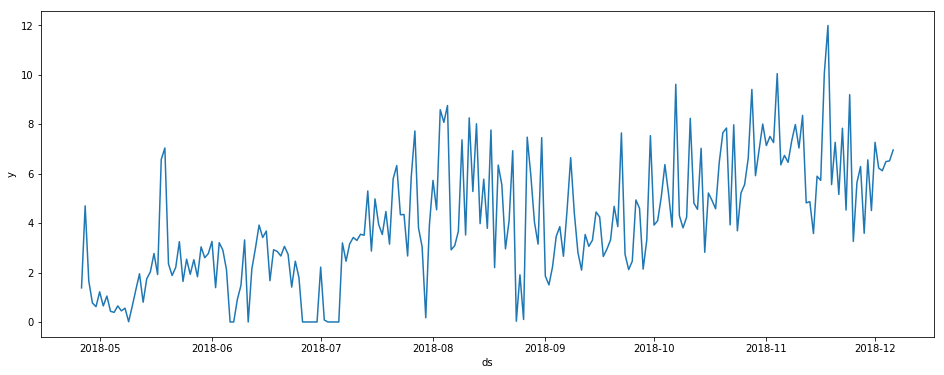

In [86]:
ddf = df[df['dayofweek'].isin([4,5,6])]

ddf.reset_index(inplace=True)
ddf['y'] = ddf.distance
ddf['ds'] = pd.to_datetime(ddf.date)

plt.figure(figsize=(16,6))
sns.lineplot(d_df.ds, d_df.y)

In [140]:
d_df['cap'] = 11
d_df['floor'] = 1

m = Prophet(daily_seasonality=False, growth='logistic', changepoint_range=0.9)
m.fit(d_df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [141]:
future = m.make_future_dataframe(periods=22)
future['cap'] = 11
future['floor'] = 1
print(future.head())
print(future.tail())
print(d_df.tail())

          ds  cap  floor
0 2018-04-26   11      1
1 2018-04-27   11      1
2 2018-04-28   11      1
3 2018-04-29   11      1
4 2018-04-30   11      1
            ds  cap  floor
242 2018-12-24   11      1
243 2018-12-25   11      1
244 2018-12-26   11      1
245 2018-12-27   11      1
246 2018-12-28   11      1
            ds     y  cap  floor
220 2018-12-02  6.23   11      1
221 2018-12-03  6.12   11      1
222 2018-12-04  6.49   11      1
223 2018-12-05  6.52   11      1
224 2018-12-06  6.96   11      1


In [142]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
242,2018-12-24,7.759910,5.300264,10.094317
243,2018-12-25,8.019242,5.608643,10.302354
244,2018-12-26,7.907006,5.573729,10.502216
245,2018-12-27,8.544317,5.772955,10.948390
246,2018-12-28,8.680330,6.303742,11.053369


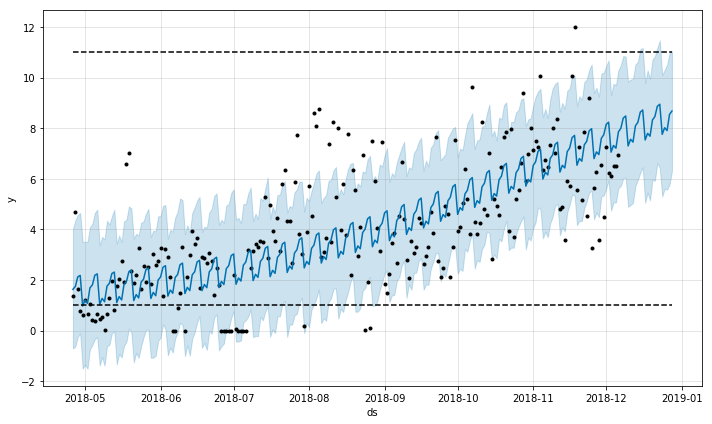

In [143]:
fig1 = m.plot(forecast)

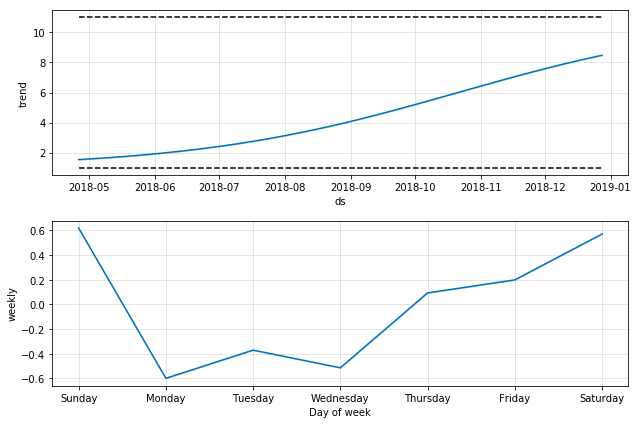

In [144]:
fig2 = m.plot_components(forecast)

In [145]:
df_cv = cross_validation(m, horizon='10 days')


df_p = performance_metrics(df_cv)
df_p.head(5)

INFO:fbprophet:Making 37 forecasts with cutoffs between 2018-05-30 00:00:00 and 2018-11-26 00:00:00


,horizon,mse,rmse,mae,mape,coverage
20,1 days,4.498059,2.120863,1.640616,inf,0.756757
171,2 days,5.125205,2.263892,1.758928,inf,0.729730
271,2 days,5.139610,2.267071,1.771429,inf,0.729730
261,2 days,5.343936,2.311695,1.843682,inf,0.729730
241,2 days,5.559607,2.357882,1.911338,inf,0.702703


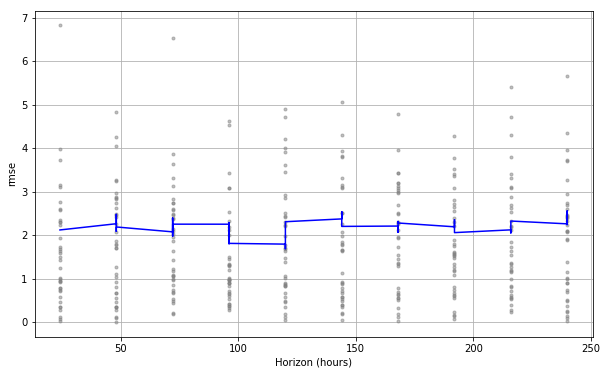

In [146]:
fig3 = plot_cross_validation_metric(df_cv, metric='rmse')

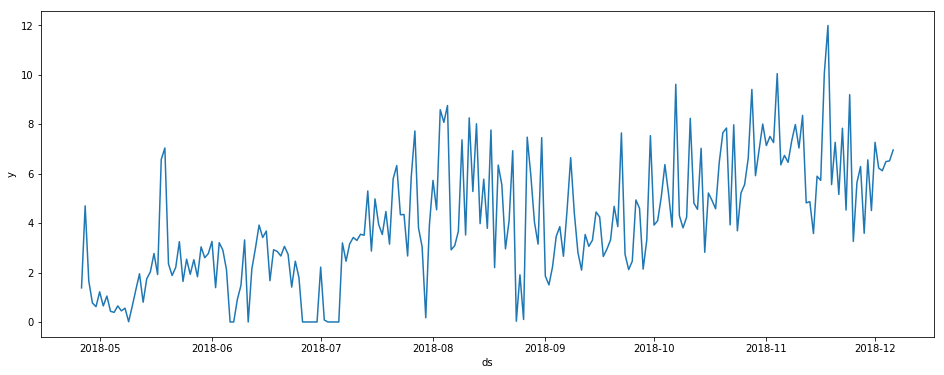

In [87]:
ddf = df[df['dayofweek'].isin([0,1,2,3])]

ddf.reset_index(inplace=True)
ddf['y'] = ddf.distance
ddf['ds'] = pd.to_datetime(ddf.date)

plt.figure(figsize=(16,6))
sns.lineplot(d_df.ds, d_df.y)

In [147]:
ddf['cap'] = 11
ddf['floor'] = 1

m = Prophet(daily_seasonality=False, growth='logistic', changepoint_range=0.9)
m.fit(ddf)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [149]:
future2 = m.make_future_dataframe(periods=22)
future2['cap'] = 11
future2['floor'] = 1
print(future2.head())
print(future2.tail())
print(ddf.tail())

          ds  cap  floor
0 2018-04-26   11      1
1 2018-04-30   11      1
2 2018-05-01   11      1
3 2018-05-02   11      1
4 2018-05-03   11      1
            ds  cap  floor
146 2018-12-24   11      1
147 2018-12-25   11      1
148 2018-12-26   11      1
149 2018-12-27   11      1
150 2018-12-28   11      1
            activity_calories  distance  floors  mins_active_high  \
date                                                                
2018-11-29             2051.0      6.56    18.0              53.0   
2018-12-03             1993.0      6.12     6.0              51.0   
2018-12-04             1663.0      6.49    13.0              67.0   
2018-12-05             1968.0      6.52    12.0              69.0   
2018-12-06             1962.0      6.96     9.0              78.0   

            mins_active_light  mins_active_med  mins_sedentary    steps  \
date                                                                      
2018-11-29              258.0             15.0        

In [151]:
forecast2 = m.predict(future)
forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
146,2018-12-24,7.688019,5.695926,9.771105
147,2018-12-25,7.957562,6.007403,10.071701
148,2018-12-26,7.848347,5.680794,9.758966
149,2018-12-27,8.489791,6.486373,10.610556
150,2018-12-28,7.729351,5.791217,9.858634


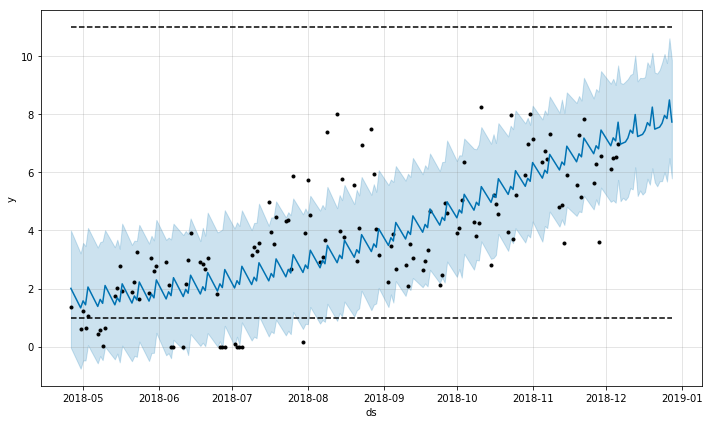

In [152]:
fig2 = m.plot(forecast2)

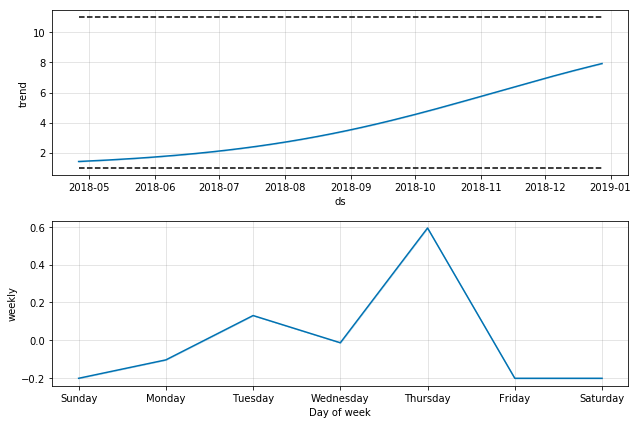

In [153]:
fig2 = m.plot_components(forecast)

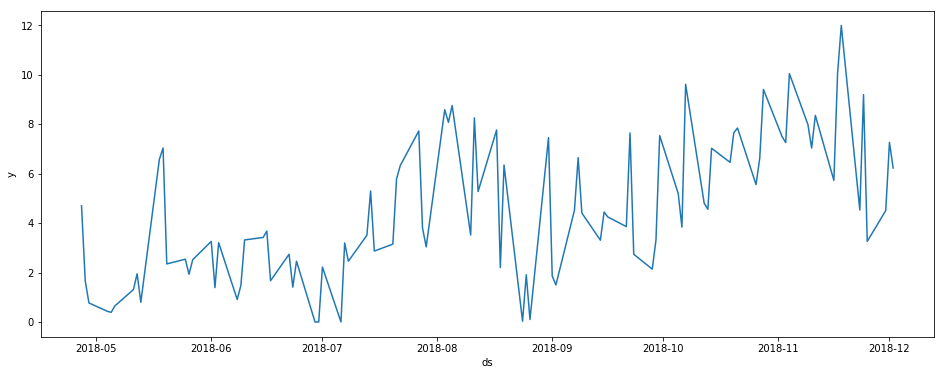

In [100]:
ddf2 = df[df['dayofweek'].isin([4,5,6])]

ddf2.reset_index(inplace=True)
ddf2['y'] = ddf2.distance
ddf2['ds'] = pd.to_datetime(ddf2.date)

plt.figure(figsize=(16,6))
sns.lineplot(ddf2.ds, ddf2.y)

In [106]:
ddf2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96 entries, 2018-04-27 to 2018-12-02
Data columns (total 20 columns):
index                96 non-null int64
activity_calories    96 non-null float64
distance             96 non-null float64
floors               96 non-null float64
mins_active_high     96 non-null float64
mins_active_light    96 non-null float64
mins_active_med      96 non-null float64
mins_sedentary       96 non-null float64
steps                96 non-null float64
total_calories       96 non-null float64
year                 96 non-null int64
quarter              96 non-null int64
month                96 non-null int64
day                  96 non-null int64
hour                 96 non-null int64
dayofweek            96 non-null int64
weekday              96 non-null object
is_weekday           96 non-null bool
y                    96 non-null float64
ds                   96 non-null datetime64[ns]
dtypes: bool(1), datetime64[ns](1), float64(10), int64(7), object(1)

In [105]:
ddf2.set_index('date', inplace=True)

In [107]:
train = ddf['2018-07-15':'2018-10'].distance.resample('D').agg('mean')
test = ddf['2018-11':'2018-12'].distance.resample('D').agg('mean')

train2 = ddf2['2018-07-15':'2018-10'].distance.resample('D').agg('mean')
test2 = ddf2['2018-11':'2018-12'].distance.resample('D').agg('mean')

print('Observations: %d' % (len(train.values) + len(test.values)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 144
Training Observations: 108
Testing Observations: 36


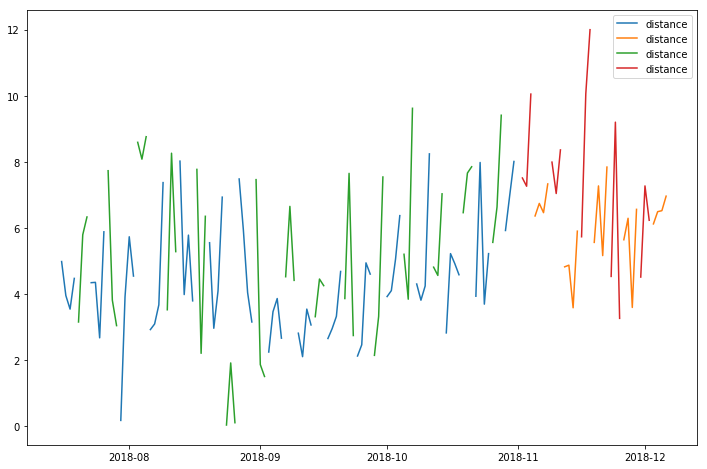

In [109]:
plt.figure(figsize=(12, 8))
plt.plot(train)
plt.plot(test)
plt.plot(train2)
plt.plot(test2)
plt.legend()
plt.show()

In [119]:
ts_data = df.distance.resample('D').agg('sum')

train_size = int(len(ts_data) * 0.85)
train_1, test_1 = ts_data[0:train_size], ts_data[train_size:len(ts_data)]
print('Observations: %d' % (len(ts_data)))
print('Training Observations: %d' % (len(train_1)))
print('Testing Observations: %d' % (len(test_1)))

Observations: 225
Training Observations: 191
Testing Observations: 34


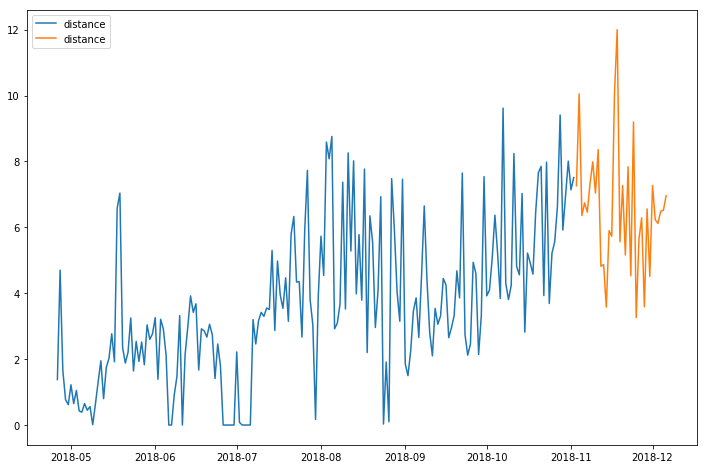

In [120]:
plt.figure(figsize=(12, 8))
plt.plot(train_1)
plt.plot(test_1)
plt.legend()
plt.show()